# Healthcare Readmissions Analysis

Preventing hospital readmissions is one of the best ways to reduce healthcare costs quickly and improve patient care in the process. This notebook demonstrates a method to predict whether a patient will be readmitted to a hospital within the 30 days after getting discharged. We use the data from 130 US hospitals for years 1999-2008 which is stored in the UCI Machine Learning Repository.

# Data Munging

This first section is to transform and prepare the raw data for analysis.

In [1]:
import pandas as pd
import numpy as np
readmissions_df = pd.read_csv('data/healthcare_data.csv')
readmissions_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


We map the different ids in the data above to human readable values and remove all the missing values.

In [2]:
#There are 50 features, out of which many are unnecessary for our purpose.
#Delete features that either have large number of missing/unknown values or will not make a difference to predicting credit risk.
readmissions_df.drop(readmissions_df.columns[[0,1,2,5,10,11,15,16,17,18,19,20,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46]], axis=1,inplace= True)

replacing_values = {"admission_type_id": {1:"Emergency", 2:"Urgent",3:"Elective",4: "Newborn", 5: np.NaN, 6: np.NaN, 7:"Trauma Center", 8:np.NaN },
                   "discharge_disposition_id": {1:"Discharged to Home",2:"Transferred to another hospital", 3:"Transferred to SNF",
                                                4:"Transferred to ICF", 5:"Transferred to another hospital", 6:"Discharged to home with home health service",
                                                7:"Discharged against Medical advice", 8:"Discharged to home with home health service",9:"Discharged to Home",
                                                10:"Transferred to another hospital", 11:"Expired", 12:"Discharged to Home", 13:"Hospice",14:"Hospice",15:"Transferred within this institution",
                                                16:"Transferred to another hospital", 17:"Transferred to another hospital", 18:np.NaN, 19:"Hospice", 20:"Hospice",21:"Hospice",
                                                22:"Transferred to another hospital", 23:"Transferred to another hospital", 24:"Transferred to SNF",25:"Transferred to another hospital",
                                                26:"Transferred to another hospital", 27:"Transferred to a federal health care facility", 28:"Transferred to another hospital", 29:"Transferred to another hospital"},
                   "admission_source_id": {1:"Physician Referral", 2:"Clinic Referral", 3:"HMO Referral", 4:"Transfer from a hospital", 5: "Transfer from a SNF", 6:"Transfer from another health care facility",
                                           7:"Emergency Room",8:"Law Enforcement", 9:np.NaN, 10:"Transfer from a hospital", 11:"Normal Delivery", 12:"Premature Delivery", 13:"Sick Baby",
                                           14:"Extramural Birth", 15:np.NaN, 17:np.NaN, 18:"Transfer from Home Health Agency", 19:"Transfer from Home Health Agency", 20: np.NaN, 21:np.NaN,
                                           22:"Transfer from a hospital",23:"Normal Delivery", 24:"Sick Baby", 25:"Transfer from Ambulatory Surgery Center", 26:"Transfer from Hospice"},
                   "age":{"[0-10)":5,"[10-20)":15,"[20-30)":25,"[30-40)":35,"[40-50)":45,"[50-60)":55,"[60-70)":65,"[70-80)":75,"[80-90)":85,"[90-100)":95},
                    "A1Cresult":{"Norm":"Normal", ">8":">7"}
                   }
readmissions_df.replace(replacing_values,inplace = True)
readmissions_df['readmitted'] = readmissions_df['readmitted'].map({"NO":0,">30":0,"<30":1})
readmissions_df.head()

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,A1Cresult,insulin,change,diabetesMed,readmitted
0,Female,5,NaN,Transferred to another hospital,Physician Referral,1,41,0,1,1,None,No,No,No,0
1,Female,15,Emergency,Discharged to Home,Emergency Room,3,59,0,18,9,None,Up,Ch,Yes,0
2,Female,25,Emergency,Discharged to Home,Emergency Room,2,11,5,13,6,None,No,No,Yes,0
3,Male,35,Emergency,Discharged to Home,Emergency Room,2,44,1,16,7,None,Up,Ch,Yes,0
4,Male,45,Emergency,Discharged to Home,Emergency Room,1,51,0,8,5,None,Steady,Ch,Yes,0


Now, we take a look at the number of rows with missing values and eliminate those rows from our dataframe.

In [3]:
print(readmissions_df.isnull().sum())

gender                          0
age                             0
admission_type_id           10396
discharge_disposition_id     3691
admission_source_id          7067
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_diagnoses                0
A1Cresult                       0
insulin                         0
change                          0
diabetesMed                     0
readmitted                      0
dtype: int64


In [4]:
print(readmissions_df.shape)
readmissions_df.dropna(inplace=True)
print(readmissions_df.shape)

(101766, 15)
(86529, 15)


In [5]:
#We make a copy of the dataframe for exploratory analysis before encoding
readmissions_orig_df = readmissions_df.copy(deep=True)

In [6]:
#One-hot encoding on all the categorical values
readmissions_df = pd.get_dummies(readmissions_df, columns=["admission_type_id","discharge_disposition_id","admission_source_id","gender", "insulin", "change","diabetesMed","A1Cresult"])
readmissions_df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,readmitted,admission_type_id_Elective,admission_type_id_Emergency,admission_type_id_Newborn,...,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,A1Cresult_>7,A1Cresult_None,A1Cresult_Normal
1,15,3,59,0,18,9,0,0,1,0,...,0,0,1,1,0,0,1,0,1,0
2,25,2,11,5,13,6,0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
3,35,2,44,1,16,7,0,0,1,0,...,0,0,1,1,0,0,1,0,1,0
4,45,1,51,0,8,5,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0
5,55,3,31,6,16,9,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0


# Exploratory Analysis

In this section, we analyze the main characteristics of the data set and explore different factors that may affect the readmission of a patient. This will help us learn more about the data before we begin predictive analysis.

In [7]:
import seaborn as sns
sns.set(font="DejaVu Sans",font_scale=1.5)
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
readmissions_orig_df.groupby('readmitted').size()

readmitted
0    76861
1     9668
dtype: int64

As we can see, this data set is quite imbalanced as almost 90% of the patients in this data set have not been readmitted within 30 days. This is helpful information to know before we measure the performace of our machine learning algorithms later on. 
Now, let us see some of the most common feature values for a patient who is readmitted.

In [9]:
#Mean feateres of a readmitted Patient
mean = readmissions_orig_df.groupby('readmitted').mean()
mean.iloc[1]

age                   66.774928
time_in_hospital       4.740588
num_lab_procedures    44.804613
num_procedures         1.273790
num_medications       16.870914
number_diagnoses       7.777307
Name: 1, dtype: float64

In [10]:
#Mode features of a readmitted Patient
modeValue = readmissions_orig_df.groupby('readmitted').agg(lambda x: x.value_counts().index[0])
modeValue.ix[1]

gender                                  Female
age                                         75
admission_type_id                    Emergency
discharge_disposition_id    Discharged to Home
admission_source_id             Emergency Room
time_in_hospital                             3
num_lab_procedures                          43
num_procedures                               0
num_medications                             15
number_diagnoses                             9
A1Cresult                                 None
insulin                                     No
change                                      Ch
diabetesMed                                Yes
Name: 1, dtype: object

As we can see from the above results, most of the readmitted patients are over 65 years old who were admitted as an Emergency and went through a large number of lab procedures and medications. 

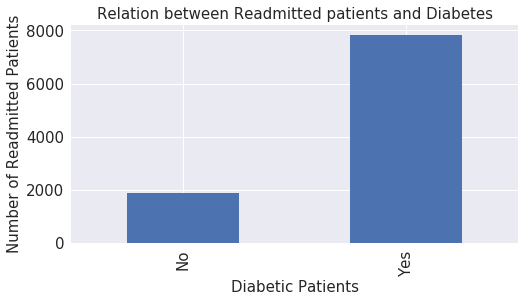

In [12]:
diabetes = readmissions_orig_df.groupby(['diabetesMed','readmitted']).size().unstack()
diabetes[1].plot(kind='bar', figsize=(8,4), fontsize=15)
plt.title("Relation between Readmitted patients and Diabetes", fontsize=15)
plt.ylabel("Number of Readmitted Patients", fontsize=15)
plt.xlabel("Diabetic Patients", fontsize=15)

From the above graph, we can see that majority of the patients who were readmitted were also diabetic. Now let's see how the types of admission and discharge can affect a patient's readmission.

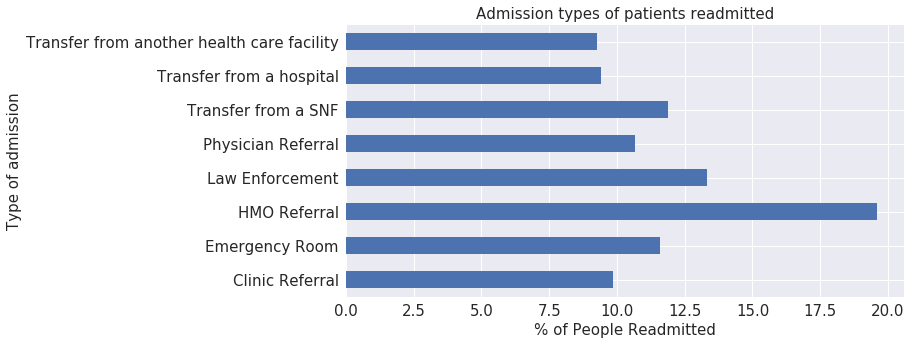

In [16]:
readmitted = readmissions_orig_df.groupby(['admission_source_id', 'readmitted']).size()
admission_type = readmitted.groupby(level=0).apply(lambda x : x / x.sum() * 100).unstack()
admission_type[1].dropna(inplace = True)
admission_type[1].drop_duplicates().plot(kind='barh', figsize=(10,5), fontsize=15)
plt.title("Admission types of patients readmitted", fontsize=15)
plt.ylabel("Type of admission", fontsize=15)
plt.xlabel("% of People Readmitted", fontsize=15)

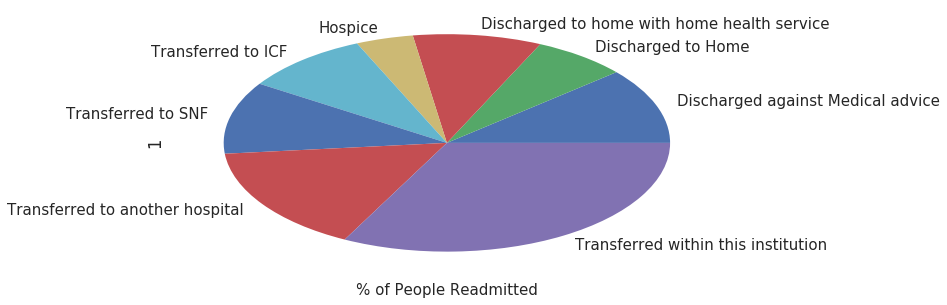

In [17]:
readmitted = readmissions_orig_df.groupby(['discharge_disposition_id', 'readmitted']).size()
readmitted_percentages = readmitted.groupby(level=0).apply(lambda x : x / x.sum() * 100).unstack()
readmitted_percentages[1].plot(kind='pie', figsize=(10,5), fontsize=15)
plt.xlabel("% of People Readmitted", fontsize=15)

# Predictive Analysis

Here, we classify the patients as readmitted within 30 days or not. We perform this task using various machine learning algorithms and also get a better understanding of important features that help us predict the readmission of a patient. 

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier

In [20]:
readmissions_df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,readmitted,admission_type_id_Elective,admission_type_id_Emergency,admission_type_id_Newborn,...,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,A1Cresult_>7,A1Cresult_None,A1Cresult_Normal
1,15,3,59,0,18,9,0,0,1,0,...,0,0,1,1,0,0,1,0,1,0
2,25,2,11,5,13,6,0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
3,35,2,44,1,16,7,0,0,1,0,...,0,0,1,1,0,0,1,0,1,0
4,45,1,51,0,8,5,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0
5,55,3,31,6,16,9,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0


In [21]:
# Create train and test dataframes.
X = readmissions_df.drop('readmitted', axis=1)
y = readmissions_df['readmitted']

In [22]:
#This method is to create n_samples of weights to handle the unbalanced data set.
def getSampleWeights(y,weight1,weight2):
    for n,i in enumerate(y):
        if i==0:
            y[n]=weight1
        if i==1:
            y[n]=weight2

In [23]:
# prepare models
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Random Forest Classifier', RFC(n_estimators=200)))
models.append(('Extra Trees Classifier', ExtraTreesClassifier(n_estimators=200, max_depth=None,min_samples_split=2, random_state=0)))
X = readmissions_df.drop('readmitted', axis=1)
y = readmissions_df['readmitted']
newY = list(y.values.flatten())
getSampleWeights(newY,1,9)

These last few steps take a while to compute due to the large size of the data set.

In [24]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy', fit_params={'sample_weight':newY})
    results.append(cv_results)
    names.append(name)
    msg = "%s: %0.2f (%0.2f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Logistic Regression: 0.50 (0.09)
Random Forest Classifier: 0.89 (0.01)
Extra Trees Classifier: 0.88 (0.01)


As we see from the above results, Random Forest Classifier yields the most accuracy. Now, choosing this model, we can select only the top few features and see how it affects our accuracy.

In [25]:
#Perform Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
skb = SelectKBest(k=20)
skb.fit(X,y)
print(X.shape)
newX = skb.transform(X)
print(newX.shape)
model = RFC(n_estimators=200)
scores = cross_val_score(model, newX,y, cv=10, scoring='accuracy',fit_params={'sample_weight':newY})
print("Accuracy: %0.2f " % (scores.mean(), scores.std() * 2))

(86529, 47)
(86529, 20)
Accuracy: 0.88 (+/- 0.00)


The above result shows us that inspite of removing more than half of the features from our data set, we still get decent accuracy and also speeds up computations.Now, using our Random Forest model, we rank the different features based on their importance in our model.

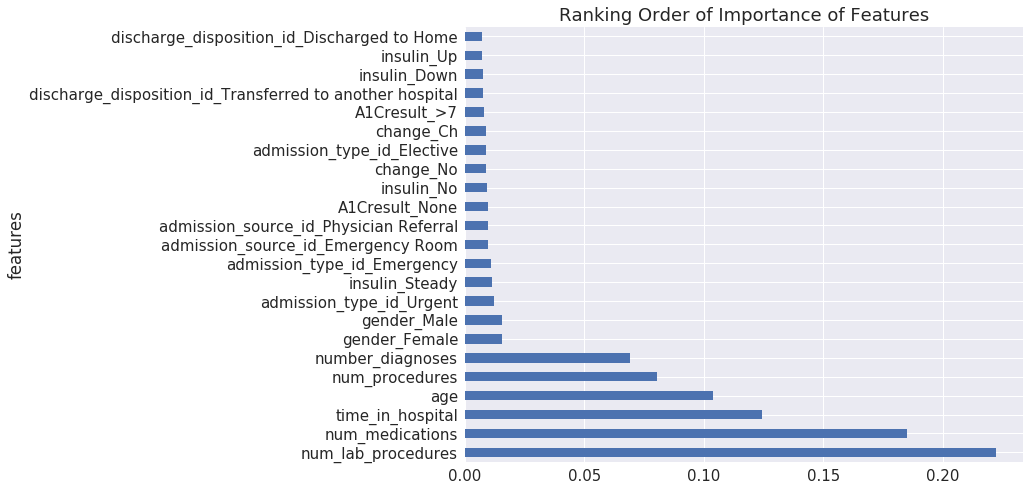

In [26]:
train, test = train_test_split(readmissions_df, test_size = 0.3)
model.fit(train.loc[:, train.columns != 'readmitted'], train['readmitted'])
cols = [col for col in train.columns if col not in ['readmitted']]
importances = pd.DataFrame({'features':cols,'importance_value':model.feature_importances_})
importances = importances.sort_values('importance_value',ascending=False).set_index('features')
importances = importances[(importances.importance_value > 0.007)]
importances.dropna().plot(figsize=(10,8), kind="barh", legend=False, title="Ranking Order of Importance of Features")

As we see from the above results, The number of lab procedures, medications and the time spent in the hospital by a patient are key features in determining whether he/she would be readmitted within 30 days.